<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [986]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

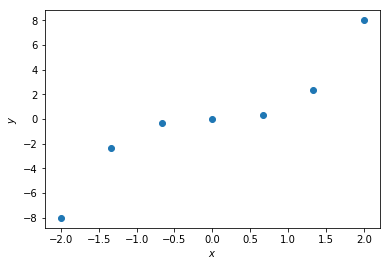

In [987]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

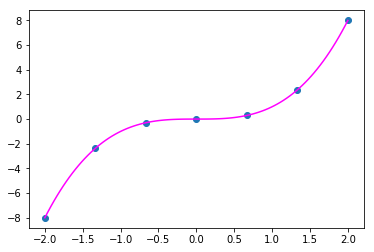

In [988]:
X_test = np.linspace(-2, 2, 100).reshape(100, 1)
y_test = X_test ** 3

plt.scatter(X, y)
plt.plot(X_test, y_test, 'magenta');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

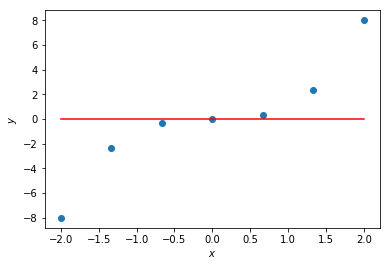

In [989]:
plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.plot(X, [np.mean(y)] * len(X), 'red');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

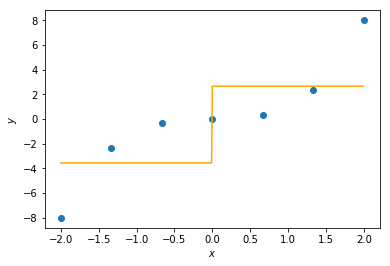

In [990]:
Z = np.arange(-2, 2, 0.01)

plt.scatter(X, y)
plt.plot(Z, [np.mean(y[X < 0]) if z < 0 else np.mean(y[X >= 0]) for z in Z], 'orange')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [991]:
def disp(X, y):
    set = len(X)
    return np.sum((y - np.sum(y) / set) ** 2) / set

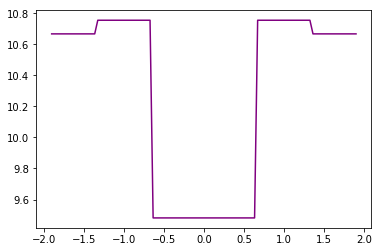

In [992]:
def regression_var_criterion(X, y, t):    
    Xl = X[X < t]
    Xr = X[X >= t]
    yl = y[X < t]
    yr = y[X >= t]
    return np.var(y) - len(Xl) / len(X) * np.var(yl) - len(Xr) / len(X) * np.var(yr)

t = np.linspace(-1.9, 1.9, 100)
plt.plot(t, [regression_var_criterion(X, y, ti) for ti in t], 'purple');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [993]:
def f(x):
    if x < 0:
        if x < -1.5:
            return np.mean(y[X < -1.5])
        else:
            return np.mean(y[(X >= -1.5) & (X < 0)])
    else:
        if x < 1.5:
            return np.mean(y[(X >= 0) & (X < 1.5)])
        else:
            return np.mean(y[X >= 1.5])

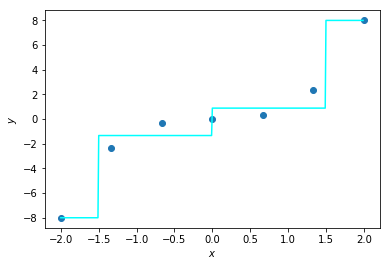

In [994]:
plt.scatter(X, y)
plt.plot(Z, [f(z) for z in Z], 'cyan')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [995]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [996]:
df['age_years'] = df['age'] // 365.25
dum_cholesterol = pd.get_dummies(df['cholesterol'], prefix='cholesterol')
dum_gluc = pd.get_dummies(df['gluc'], prefix='gluc')
df = pd.concat([df, dum_cholesterol, dum_gluc], axis=1)
y = df['cardio']
df.drop(['age', 'cholesterol', 'gluc', 'cardio'], inplace=True, axis=1)
df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,50.0,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,55.0,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,51.0,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,48.0,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,47.0,1,0,0,1,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [997]:
# Ваш код здесь

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [998]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [999]:
from IPython.display import Image

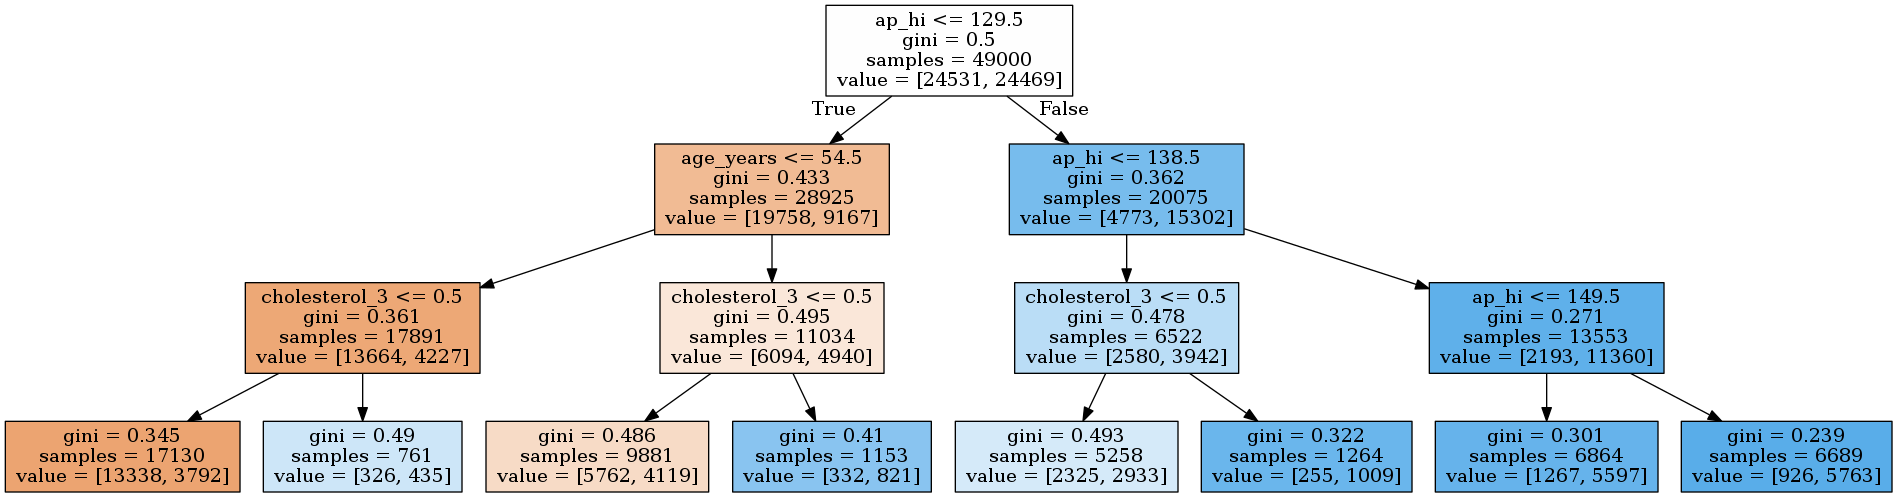

In [1000]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)
export_graphviz(tree, out_file='tree_one.dot', filled=True, feature_names=df.columns)
!dot -Tpng 'tree_one.dot' -o 'tree_one.png'
Image('tree_one.png')

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [1001]:
tree_valid_pred = tree.predict(X_valid)
acc = accuracy_score(y_valid, tree_valid_pred)
round(acc, 3)

0.721

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [1002]:
tree_params = {'max_depth': list(range(2, 11))}

In [1003]:
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5)

In [1004]:
%%time
tree_grid.fit(X_train, y_train)

CPU times: user 2.97 s, sys: 10 ms, total: 2.98 s
Wall time: 2.99 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

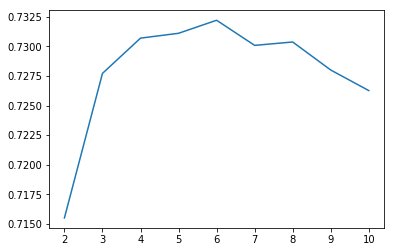

In [1005]:
plt.plot(tree_params['max_depth'], tree_grid.cv_results_['mean_test_score']);

In [1006]:
tree_grid.best_score_, tree_grid.best_params_

(0.732204081632653, {'max_depth': 6})

In [1007]:
acc2 = tree_grid.best_score_
acc2

(acc2 - acc)/acc*100

1.51373680785445

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [1008]:
df2['male'] = df['gender'] - 1
df2['age_45'] = df['age_years'].between(45, 49).astype(np.int)
df2['age_50'] = df['age_years'].between(50, 54).astype(np.int)
df2['age_55'] = df['age_years'].between(55, 59).astype(np.int)
df2['age_60'] = df['age_years'].between(60, 64).astype(np.int)
df2['ap_120'] = df['ap_hi'].between(120, 139).astype(np.int)
df2['ap_140'] = df['ap_hi'].between(140, 159).astype(np.int)
df2['ap_160'] = df['ap_hi'].between(160, 179).astype(np.int)

In [1009]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 15 columns):
smoke            70000 non-null int64
cholesterol_1    70000 non-null uint8
cholesterol_2    70000 non-null uint8
cholesterol_3    70000 non-null uint8
gluc_1           70000 non-null uint8
gluc_2           70000 non-null uint8
gluc_3           70000 non-null uint8
male             70000 non-null int64
age_45           70000 non-null int64
age_50           70000 non-null int64
age_55           70000 non-null int64
age_60           70000 non-null int64
ap_120           70000 non-null int64
ap_140           70000 non-null int64
ap_160           70000 non-null int64
dtypes: int64(9), uint8(6)
memory usage: 5.7 MB


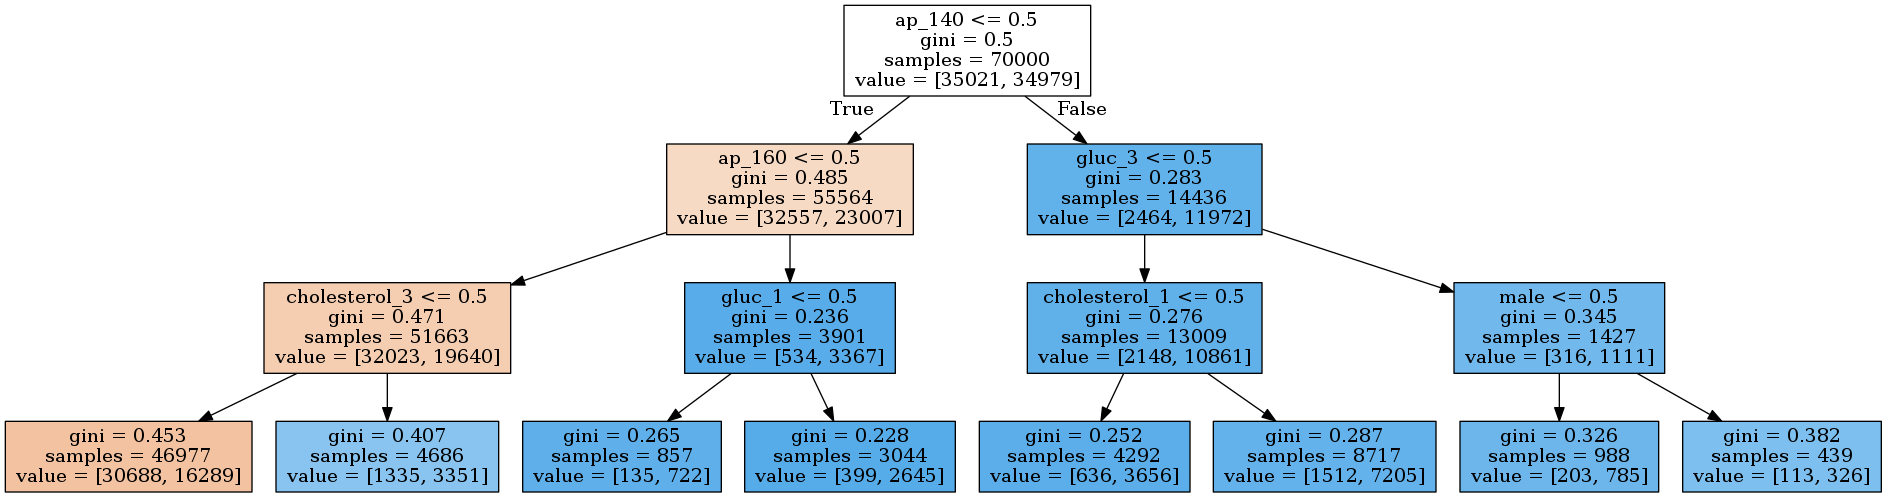

In [1010]:
tree_n = DecisionTreeClassifier(max_depth=3, random_state=17)
tree_n.fit(df2, y)
export_graphviz(tree_n, out_file='tree_t.dot', filled=True, feature_names=df2.columns)
!dot -Tpng 'tree_t.dot' -o 'tree_t.png'
Image('tree_t.png')